# Logistic Regression

En esta notebook vamos a analizar el caso propuesto en la página 146 del Hands-On

La Regresión logística es comunmente utilizada ára estimar la probabilidad a posteriori de que una instancia pertenezca a una clase en particular

## Estimando probabilidades

Funciona de la misma manera de un modelo de regresión lineal. La Regresión logística calcula la suma pesada de las características de entrada, más el termino de regularización, y como _output_ contiene el resultado de aplicar la función logística.

$$ \hat{p} = h_{\theta}(x)=\sigma (x^{T} \theta)$$

Donde la función sigmoide está definida de la siguiente manera
$$\sigma (t) = \frac{1}{1+ \mathrm{e}^{-t}}$$

Una vez que el modelo de regresión logística estimó la probabilidad de $\hat{p}$

In [67]:
from sklearn import datasets
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
StratifiedKFold, GroupShuffleSplit,
GroupKFold, StratifiedShuffleSplit,cross_val_score)
from sklearn.linear_model import (LogisticRegression,LogisticRegressionCV)
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
from sklearn.metrics import plot_confusion_matrix

In [29]:
iris = datasets.load_iris()
list(iris.keys())
['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [30]:
unique, counts = np.unique(iris["target"], return_counts=True)
dict(zip(unique, counts))

{0: 50, 1: 50, 2: 50}

Transformamos el dataset Iris a un dataframe para facilitar su manipulación

In [31]:
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
iris_df = pd.DataFrame(iris['data'], columns=features)
iris_df['species'] = iris["target"]
iris_df['species'] = iris_df['species'].map({0: "setosa", 1: "versicolor", 2: "virginica"})
iris_df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


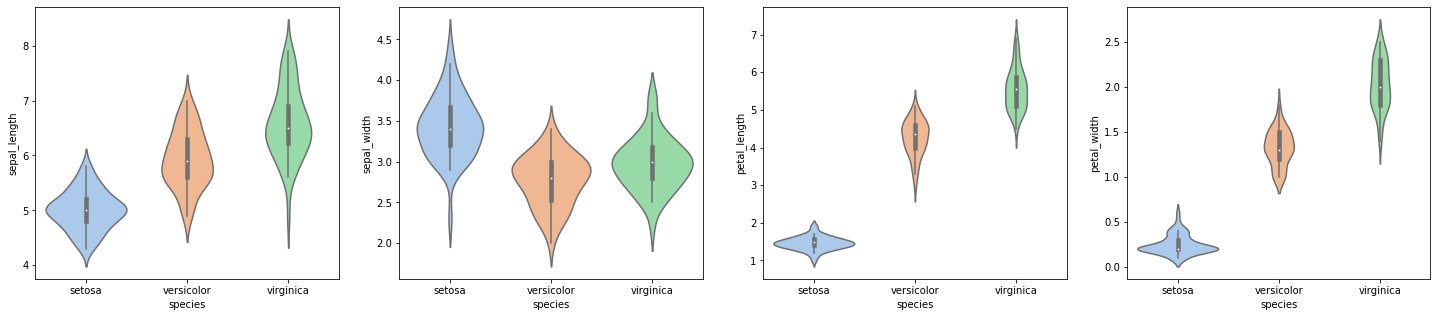

In [123]:
fig, axes = plt.subplots(1, 4, figsize=(25,5))
for i in range(4):
   sns.violinplot(x='species',y=features[i], data=iris_df, palette='pastel',ax=axes[i])

## [**Regresion logística**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [32]:
#Modelo de regresion logística entrenado sobre uno de los atributos (petal width en este caso)
X = iris["data"][:, 3:] # petal width
y = (iris["target"] == 2).astype(np.int64) # 1 if Iris virginica, else 0
log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

## Fronteras de decisión establecidas por el modelo

A continuación presentamos un gráfico que incluye las fronteras de decision establecida por las densidades probabilisticas

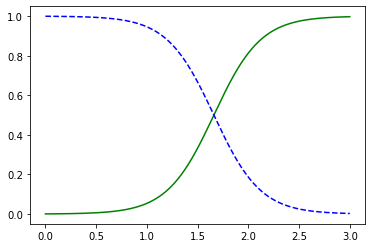

In [7]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-", label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris virginica")


In [8]:
log_reg.predict_proba([[1.7], [1.5]]) #-> te da las medidas de probabilidad acordes a cada clase

array([[0.45722097, 0.54277903],
       [0.66709636, 0.33290364]])

### Regresión logística multiclases con las 4 variables

A continuación vamos a utilizar Softmax regression para realizar la predicción considerando cada tipo de planta

In [32]:
X = iris["data"] # las 4 variables
y = iris["target"]
softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", 
                                 C=10, max_iter=145)
softmax_reg.fit(X, y)

LogisticRegression(C=10, max_iter=145, multi_class='multinomial')

In [34]:
softmax_reg.predict([[5, 2, 1, 3]])

array([0])

# Dividimos el dataset en train y test de forma estratificada

In [111]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for train_index, test_index in split.split(iris_df, iris_df["species"]):
    strat_train_set = iris_df.loc[train_index]
    strat_test_set = iris_df.loc[test_index]

In [112]:
train = strat_train_set.drop("species", axis=1)
train_labels = strat_train_set["species"]

strat_train_set['species'].value_counts()

versicolor    25
setosa        25
virginica     25
Name: species, dtype: int64

In [113]:
test = strat_test_set.drop("species", axis=1)
test_labels = strat_test_set["species"]

strat_test_set['species'].value_counts()

versicolor    25
setosa        25
virginica     25
Name: species, dtype: int64

## Búsqueda de hiperparámetros

A continuación vamos a realizar la búsqueda exhaustiva de hiperparámetros utilizando GridsearchCV

In [114]:
def selectValuesForHyperparameter(initialValue, lastValue, jumps):
    rv = []
    for v in range(int(initialValue*100), int(lastValue*100),int(jumps*100)):
        rv.append(float(v/100));
    return rv 

In [115]:
cValues = selectValuesForHyperparameter(1.0, 50,0.1)

params = {'C':cValues, 'solver':['newton-cg', 'lbfgs','sag']}
softmax_reg = LogisticRegression(multi_class="multinomial", max_iter=3000)
clf_reg = GridSearchCV(softmax_reg, params, cv=10,
                                scoring='neg_log_loss', #-> este scoring lo sacamos del Hands' On 
                                return_train_score=True)
clf_reg.fit(train, train_labels)
clf_reg.best_params_   

{'C': 39.3, 'solver': 'lbfgs'}

In [116]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

## Train and cross validation

Dividimos el dataset en _train_ y _test_ de forma estratificada sobre los tipos de plantas y luego entrenamos el modelo utilizando cross validation

In [129]:
#Entrenamos el modelo con los hiperparametros encontrados con GridsearchCV
softmax_reg = LogisticRegressionCV(cv=10,Cs=[clf_reg.best_params_['C']],
                                   solver=clf_reg.best_params_['solver'],
                                   random_state=0,
                                   scoring='neg_log_loss',
                                   max_iter=3000,
                                   multi_class='multinomial').fit(train, train_labels)


Exploramos como alterantiva a la busqueda de hiperparámetros con GridsearchCV la utilizacion del atributo refit de LogisticRegressionCV

In [118]:
l1Values = selectValuesForHyperparameter(0.1, 1, 0.1); 
cValues = selectValuesForHyperparameter(5.0, 50,0.1)
#Este va a ser un modelo que usa penalidad elasticnet y aprovecha el refit para encontrar los mejores parametros
softmax_reg_withElastic = LogisticRegressionCV(cv=10,Cs=cValues,solver='saga',
                                   random_state=0,
                                    penalty='elasticnet',
                                   scoring='neg_log_loss',
                                  max_iter=3000,
                                  l1_ratios=l1Values,
                                  multi_class='multinomial',
                                refit=True).fit(train, train_labels)

print("el mejor hiperparametro encontrado para C es:"+str(softmax_reg_withElastic.C_))
print("el mejor hiperparametro encontrado para l1 ratio es:"+str(softmax_reg_withElastic.l1_ratio_))

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter wa

el mejor hiperparametro encontrado para C es:[49.9 49.9 49.9]
el mejor hiperparametro encontrado para l1 ratio es:[0.8 0.8 0.8]


## Alternativa

Entrenamos usando todas las features menos sepal_width

In [130]:
#Entrenamos el modelo con los hiperparametros encontrados con GridsearchCV sin usar el atributo sepal width
train_withoutSepalWidth = train.drop("sepal_width",axis=1)
reg_withoutSepalWidth = LogisticRegressionCV(cv=10,Cs=[clf_reg.best_params_['C']],
                                   solver=clf_reg.best_params_['solver'],
                                   random_state=0,
                                   scoring='neg_log_loss',
                                   max_iter=3000,
                                   multi_class='multinomial').fit(train_withoutSepalWidth, train_labels)

In [120]:
l1Values = selectValuesForHyperparameter(0.1, 1, 0.1); 
cValues = selectValuesForHyperparameter(5.0, 50,0.1)
reg_withElastic_withoutSepalWidth = LogisticRegressionCV(cv=10,Cs=cValues,solver='saga',
                                   random_state=0,
                                    penalty='elasticnet',
                                   scoring='neg_log_loss',
                                  max_iter=3000,
                                  l1_ratios=l1Values,
                                  multi_class='multinomial',
                                refit=True).fit(train_withoutSepalWidth, train_labels)

print("el mejor hiperparametro encontrado para C es:"+str(softmax_reg_withElastic.C_))
print("el mejor hiperparametro encontrado para l1 ratio es:"+str(softmax_reg_withElastic.l1_ratio_))

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter wa

el mejor hiperparametro encontrado para C es:[49.9 49.9 49.9]
el mejor hiperparametro encontrado para l1 ratio es:[0.8 0.8 0.8]


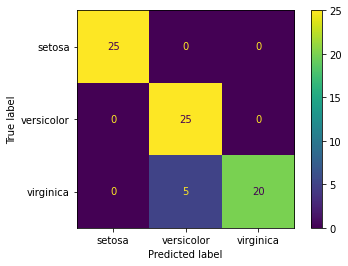

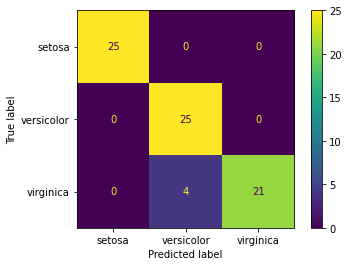

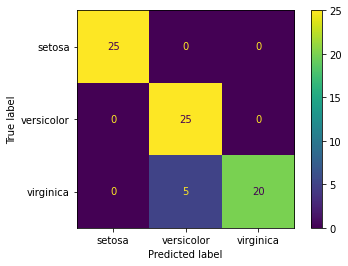

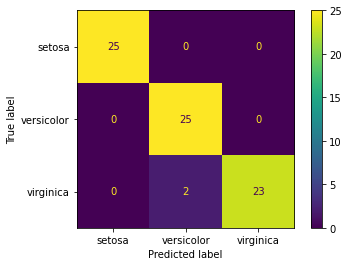

In [131]:
x_test = strat_test_set.iloc[:,0:4]
y_test = strat_test_set.iloc[:,4]
x_test_withoutSepalWidth = strat_test_set.drop("sepal_width",axis=1).iloc[:,0:3]

plot_confusion_matrix(softmax_reg, x_test, y_test) 
plot_confusion_matrix(softmax_reg_withElastic, x_test, y_test) 
plot_confusion_matrix(reg_withoutSepalWidth, x_test_withoutSepalWidth, y_test) 
plot_confusion_matrix(reg_withElastic_withoutSepalWidth, x_test_withoutSepalWidth, y_test) 

In [126]:
especies = {0: "setosa", 1: "versicolor", 2: "virginica"}

In [122]:
# predicción de la clase de pertenencia
softmax_reg.predict([[5, 3, 2, 1]])
# pb de pertenencia a cada clase
softmax_reg.predict_proba([[5, 3, 2, 1]])

array([[9.30483452e-01, 6.95164962e-02, 5.18104701e-08]])

In [135]:
# predicción de la clase de pertenencia
print("Prueba de prediccion para un iris \n con sépalo de largo 5 y ancho 3 \n y con pétalo de largo 2 y ancho 1\n")
print("Predice:"+softmax_reg.predict([[5, 3, 2, 1]])[0]+'\n')
# pb de pertenencia a cada clase
print("Con probabilidad para cada clase:")
print(softmax_reg_withElastic.predict_proba([[5, 3, 2, 1]]))
print("----------------------------")
print("\nUsando penalidad ElasticNet predice:"+softmax_reg_withElastic.predict([[5, 3, 2, 1]])[0]+'\n')
# pb de pertenencia a cada clase
print("Con probabilidad para cada clase:")
print(softmax_reg_withElastic.predict_proba([[5, 3, 2, 1]]))
print("----------------------------")
print("\nSin usar sepal width predice:"+reg_withoutSepalWidth.predict([[5, 2, 1]])[0]+'\n')
# pb de pertenencia a cada clase
print("Con probabilidad para cada clase:")
print(reg_withoutSepalWidth.predict_proba([[5, 2, 1]]))
print("----------------------------")
print("\nSin usar sepal width con penalidad ElasticNet predice:"+reg_withElastic_withoutSepalWidth.predict([[5, 2, 1]])[0]+'\n')
# pb de pertenencia a cada clase
print("Con probabilidad para cada clase:")
print(reg_withElastic_withoutSepalWidth.predict_proba([[5, 2, 1]]))

Prueba de prediccion para un iris 
 con sépalo de largo 5 y ancho 3 
 y con pétalo de largo 2 y ancho 1

Predice:setosa

Con probabilidad para cada clase:
[[9.84849438e-01 1.51505624e-02 3.87141815e-12]]
----------------------------

Usando penalidad ElasticNet predice:setosa

Con probabilidad para cada clase:
[[9.84849438e-01 1.51505624e-02 3.87141815e-12]]
----------------------------

Sin usar sepal width predice:setosa

Con probabilidad para cada clase:
[[9.71166535e-01 2.88334645e-02 4.42193486e-12]]
----------------------------

Sin usar sepal width con penalidad ElasticNet predice:setosa

Con probabilidad para cada clase:
[[9.23498946e-01 7.65010231e-02 3.04869623e-08]]
